In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Dynamical Movement Primitive (DMPs)
===================================

DMPs are trajectory representations that

* are goal-directed
* are robust to perturbations and noise (like potential fields)
* are arbitrarily shapeable
* can be scaled and translated arbitrarily, even online
* are parametrized policy representations that can be used for reinforcement learning
* can be used for imitation learning

They have drawbacks:

* an inverse (velocity) kinematics is required to execute task space trajectories
* they are usually not able to learn from multiple demonstrations

There are different variants of DMPs in the literature [1, 2, 3].

[1] Ijspeert, Auke Jan; Nakanishi, Jun; Hoffmann, Heiko; Pastor, Peter; Schaal, Stefan: Dynamical movement primitives: learning attractor models for motor behaviors, Neural computation 25 (2), pp. 328-373, 2013.

[2] Pastor, Peter; Hoffmann, Heiko; Asfour, Tamim; Schaal, Stefan: Learning and generalization of motor skills by learning from demonstration, Proceedings of the IEEE International Conference on Robotics and Automation, pp. 763-768, 2009.

[3] Muelling, Katharina; Kober, Jens; Kroemer, Oliver; Peters, Jan: Learning to Select and Generalize Striking Movements in Robot Table Tennis, International Journal of Robotics Research 32 (3), 2013.

In [2]:
def clean_ax(ax, x_range, y_range, spines=False, legend=False):
    if legend:
        ax.legend(loc="upper left")
    if not spines:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
    plt.setp(ax, xticks=(), yticks=(), xlim=x_range, ylim=y_range)

## Mass-spring-damper

![Spring-damper](http://upload.wikimedia.org/wikipedia/commons/3/35/%D0%9A%D0%BE%D0%BB%D0%B8%D0%B2%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%B0_%D1%96%D0%B7_%D0%BF%D1%80%D1%83%D0%B6%D0%B8%D0%BD%D0%BE%D1%8E_%D1%82%D0%B0_%D0%B4%D0%B5%D0%BC%D0%BF%D1%84%D0%B5%D1%80%D0%BE%D0%BC.png)

* An oscillatory force $F_s = -k x$
* and a damping force $F_d = -c \dot{x}$
* result in a total force $F_{tot} = m \ddot{x}$

$$F_{tot} = F_s + F_d \Leftrightarrow \ddot{x} + \frac{c}{m} \dot{x} + \frac{k}{m} x = 0$$

The system is critically damped, i.e. it converges to zero as fast as possible without oscillating (overshoot can occur), iff
$$c = 2 \sqrt{mk}$$

[Wikipedia: Damping](http://en.wikipedia.org/wiki/Damping)

The dynamical system that we use in a Dynamical Movement Primitive is based on a spring-damper system with $m=1$. The original formulation by Ijspeert et al. computes the acceleration by
$$\ddot{x} = \frac{\alpha}{\tau^2} \left(\beta (g - x) - \tau \dot{x}\right),$$
which can be reformulated as
$$x + \frac{\tau}{\beta} \dot{x} + \frac{\tau^2}{\alpha \beta} \ddot{x} = g,$$
so that critical damping is achieved with
$$\frac{\tau}{\beta} = 2 \sqrt{\frac{\tau^2}{\alpha \beta}}
  \Leftrightarrow \frac{\alpha}{4} = \beta.$$

In addition, the DMP has a nonlinear forcing term that defines the shape of the movement over time.
$$\tau^2 \ddot{x} = \alpha \left(\beta (g - x) - \tau \dot{x}\right) + f(s),$$
where $s$ is the so called phase.

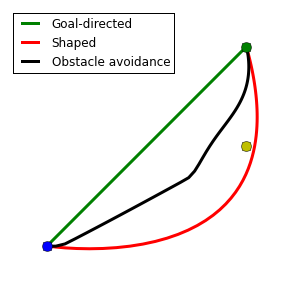

In [3]:
from dmp import DMP, trajectory, potential_field

x0 = np.array([0, 0], dtype=np.float64)
g = np.array([1, 1], dtype=np.float64)
tau = 1.0
w = np.array([[-50.0, 100.0, 300.0],
              [-200.0, -200.0, -200.0]])
o = np.array([1.0, 0.5])
dt = 0.01

dmp = DMP()

x_range = (-0.2, 1.2)
y_range = (-0.2, 1.2)
n_tics = 10

G, _ = trajectory(dmp, w, x0, g, tau, dt, o, shape=False, avoidance=False)
T, _ = trajectory(dmp, w, x0, g, tau, dt, o, shape=True, avoidance=False)
O, _ = trajectory(dmp, w, x0, g, tau, dt, o, shape=True, avoidance=True)

fig = plt.figure(figsize=(5, 5))

plt.plot(G[:, 0], G[:, 1], lw=3, color="g", label="Goal-directed")
plt.plot(T[:, 0], T[:, 1], lw=3, color="r", label="Shaped")
plt.plot(O[:, 0], O[:, 1], lw=3, color="black", label="Obstacle avoidance")

plt.plot(x0[0], x0[1], "o", color="b", markersize=10)
plt.plot(g[0], g[1], "o", color="g", markersize=10)
plt.plot(o[0], o[1], "o", color="y", markersize=10)

clean_ax(plt.gca(), x_range=x_range, y_range=y_range, legend=True)

In [4]:
def potential_trajectory(dmp, t_max, dt, shape, avoidance):
    T, Td = trajectory(dmp, w, x0, g, tau, dt, o, shape, avoidance)
    X, Y, sd, f, C, acc = potential_field(
        dmp, t_max, Td[t_max - 1],
        w, x0, g, tau, dt, o, x_range, y_range, n_tics)
    if not avoidance:
        acc -= C
    return T[:t_max], X, Y, sd, f, C, acc

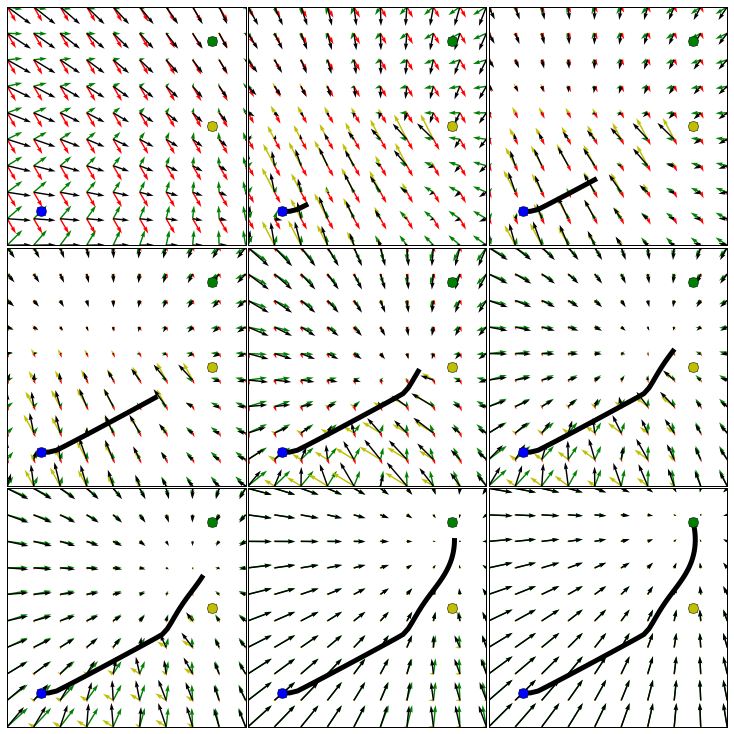

In [5]:
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.01, hspace=0.01)
for i, t in enumerate([1, 5, 10, 15, 20, 25, 30, 50, 99]):
    ax = plt.subplot(3, 3, 1 + i, aspect="equal")

    T, X, Y, sd, f, C, acc = potential_trajectory(
        dmp, t, dt, shape=True, avoidance=True)

    plt.plot(T[:, 0], T[:, 1], lw=5, color="black")

    quiver_scale = np.abs(acc).max() * n_tics
    plt.quiver(X, Y, sd[:, :, 0], sd[:, :, 1], scale=quiver_scale, color="g")
    plt.quiver(X, Y, f[:, :, 0], f[:, :, 1], scale=quiver_scale, color="r")
    plt.quiver(X, Y, C[:, :, 0], C[:, :, 1], scale=quiver_scale, color="y")
    plt.quiver(X, Y, acc[:, :, 0], acc[:, :, 1], scale=quiver_scale, color="black")

    plt.plot(x0[0], x0[1], "o", color="b", markersize=10)
    plt.plot(g[0], g[1], "o", color="g", markersize=10)
    plt.plot(o[0], o[1], "o", color="y", markersize=10)

    clean_ax(ax, x_range=x_range, y_range=y_range, spines=True, legend=False)

Dependencies

sudo pip install git+https://github.com/jakevdp/ipywidgets.git

In [6]:
from ipywidgets import StaticInteract, RangeWidget

def plot(step):
    t = int(step)
    fig, ax = plt.subplots(figsize=(7, 7))

    T, X, Y, sd, f, C, acc = potential_trajectory(
        dmp, t, dt, shape=True, avoidance=True)

    plt.plot(T[:, 0], T[:, 1], lw=5, color="black")

    quiver_scale = np.abs(acc).max() * n_tics
    plt.quiver(X, Y, sd[:, :, 0], sd[:, :, 1], scale=quiver_scale, color="g")
    plt.quiver(X, Y, f[:, :, 0], f[:, :, 1], scale=quiver_scale, color="r")
    plt.quiver(X, Y, C[:, :, 0], C[:, :, 1], scale=quiver_scale, color="y")
    plt.quiver(X, Y, acc[:, :, 0], acc[:, :, 1], scale=quiver_scale, color="black")

    plt.plot(x0[0], x0[1], "o", color="b", markersize=10)
    plt.plot(g[0], g[1], "o", color="g", markersize=10)
    plt.plot(o[0], o[1], "o", color="y", markersize=10)

    clean_ax(ax, x_range=x_range, y_range=y_range, spines=True, legend=False)
    return fig


StaticInteract(plot, step=RangeWidget(5.0, 95.0, 5.0))

## Imitation Learning

$$\tau^2 \ddot{x} = \alpha \left(\beta (g - x) - \tau \dot{x}\right) + f(s)$$
can be rearranged to
$$f(s) = \tau^2 \ddot{x} - \alpha \left(\beta (g - x) - \tau \dot{x}\right)$$

TODO
====

* imitation learning
* Muelling's DMP
* goal adaption
* parametric DMPs
* episodic REPS